In [1]:
!pip install xgboost

# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import re
import os
sb.set()

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# 3D visualizer
from mpl_toolkits.mplot3d import Axes3D

# ANOVA Test
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# XGBoost
from xgboost import XGBRegressor
from xgboost import cv
import xgboost as xgb
from xgboost import plot_importance

# array for storing results
models = []
results = []

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/jwong002/sc1015project/main/train_cleaned.csv')
data.head()

,Animal ID,Name_intake,DateTime_intake,MonthYear_intake,Intake_Type,IntakeCondition,Animal_Type_intake,Sex,Age,Breed_intake,...,Outcome_Subtype,Sex_upon_Outcome,Age_upon_Outcome,Gender,fixed_intake,fixed_outcome,fixed_changed,Age_Bucket,Days_length,DateTime_length
0,A670057,Brownie,2014-01-01 13:05:00,2014-01-01,Stray,Normal,Dog,Intact Male,2 years,chow chow,...,Unknown,Neutered Male,2 years,Male,Intact,Neutered,1,1-3 years,0-7 days,4 days 03:45:00
1,A670059,NoName,2014-01-01 13:31:00,2014-01-01,Stray,Normal,Dog,Spayed Female,1 year,west highland,...,Unknown,Spayed Female,1 year,Female,Spayed,Spayed,0,1-3 years,0-7 days,4 days 01:06:00
2,A670061,Koda,2014-01-01 13:33:00,2014-01-01,Owner Surrender,Normal,Dog,Intact Male,2 years,chow chow,...,Unknown,Neutered Male,2 years,Male,Intact,Neutered,1,1-3 years,3-6 weeks,23 days 00:08:00
3,A670064,NoName,2014-01-01 13:57:00,2014-01-01,Stray,Normal,Dog,Intact Female,3 months,pit bull/pit bull,...,In Kennel,Intact Female,3 months,Female,Intact,Intact,0,1-6 months,0-7 days,2 days 02:36:00
4,A670065,Muneca,2014-01-01 14:11:00,2014-01-01,Stray,Normal,Dog,Spayed Female,7 years,australian shepherd/chow chow,...,Unknown,Spayed Female,7 years,Female,Spayed,Spayed,0,7+ years,0-7 days,0 days 21:41:00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152273 entries, 0 to 152272
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Animal ID           152273 non-null  object
 1   Name_intake         152273 non-null  object
 2   DateTime_intake     152273 non-null  object
 3   MonthYear_intake    152273 non-null  object
 4   Intake_Type         152273 non-null  object
 5   IntakeCondition     152273 non-null  object
 6   Animal_Type_intake  152273 non-null  object
 7   Sex                 152273 non-null  object
 8   Age                 152273 non-null  object
 9   Breed_intake        152273 non-null  object
 10  Color_intake        152273 non-null  object
 11  Name_outcome        152273 non-null  object
 12  DateTime_outcome    152273 non-null  object
 13  MonthYear_outcome   152273 non-null  object
 14  Outcome_Type        152273 non-null  object
 15  Outcome_Subtype     152273 non-null  object
 16  Se

# **Checking the data types and converting them if necessary**

In [4]:
#Function to convert 'Age' to days
def range_to_days(age_str):
    # This regex will find all the numbers and their associated units
    matches = re.findall(r'(\d+)\s*(year|month|week|day)s?', age_str.lower())
    # Convert each found match to the number of days
    day_counts = {
        'year': 365,
        'month': 30,
        'week': 7,
        'day': 1
    }
    return sum(int(number) * day_counts[unit] for number, unit in matches)

#Apply these functions to the dataframe
data['Age_in_days'] = data['Age'].apply(range_to_days)
data['Days_length_numeric'] = data['Days_length'].apply(range_to_days)

#Check the first few rows to verify the transformation
data[['Age', 'Age_in_days', 'Days_length', 'Days_length_numeric']].head()

,Age,Age_in_days,Days_length,Days_length_numeric
0,2 years,730,0-7 days,7
1,1 year,365,0-7 days,7
2,2 years,730,3-6 weeks,42
3,3 months,90,0-7 days,7
4,7 years,2555,0-7 days,7


In [5]:
data['DateTime_length'] = pd.to_timedelta(data['DateTime_length'])

# Extract just the days component of 'DateTime_length'
data['Days_length2'] = data['DateTime_length'].dt.days

# **Dropping rows with NaN values after the conversion**

In [6]:
data = data.dropna(subset=['Age', 'Days_length'])

# **Developing ML Models**

We want to know how to optimize the management of animal shelters and increase adoption rates:

- use numerical data:
     - with univariate linear regresion   

- use numerical and categorical data:
     - general feature selection and data preparation
     - with decision trees
     - with random forest
     - lasso regression
     - XGBoost

# **1. Using Numerical Data**

# **1.1 Univariate Linear Regression**

Univariate linear regression provides a basic but powerful tool for exploring linear relationships between two continuous variables. It helps us understand the direction and strength of the association and estimate the predicted value of the dependent variable for a given value of the independent variable. 

In [7]:
# Define the feature (independent variable) and the target (dependent variable)
X = data[['Age_in_days']]  # Features (2D array for sklearn)
y = data[['Days_length2']]      # Target variable

In [8]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
test_data = pd.DataFrame(data)

# Change to the desired directory (using raw string to handle backslashes correctly)
os.chdir(r'C:\Users\Asus\Downloads\test data')

# Save the DataFrame in the new directory if you changed the directory
test_data.to_csv('test_data.csv', index=False)  

In [10]:
# Initialize the model
model = LinearRegression()
# Train the model using the training sets
model.fit(X_train, y_train)

LinearRegression()

In [11]:
#Create the linear regression object
linreg = LinearRegression()
#Train the linear regression model
linreg.fit(X_train, y_train)

# Formula for the Regression line
regline_x = X_train
regline_y = linreg.intercept_ + linreg.coef_ * X_train

# Print the coefficients of the Regression Line
print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

Intercept 	: b =  [16.59608206]
Coefficients 	: a =  [[-0.00122618]]


In [12]:
# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

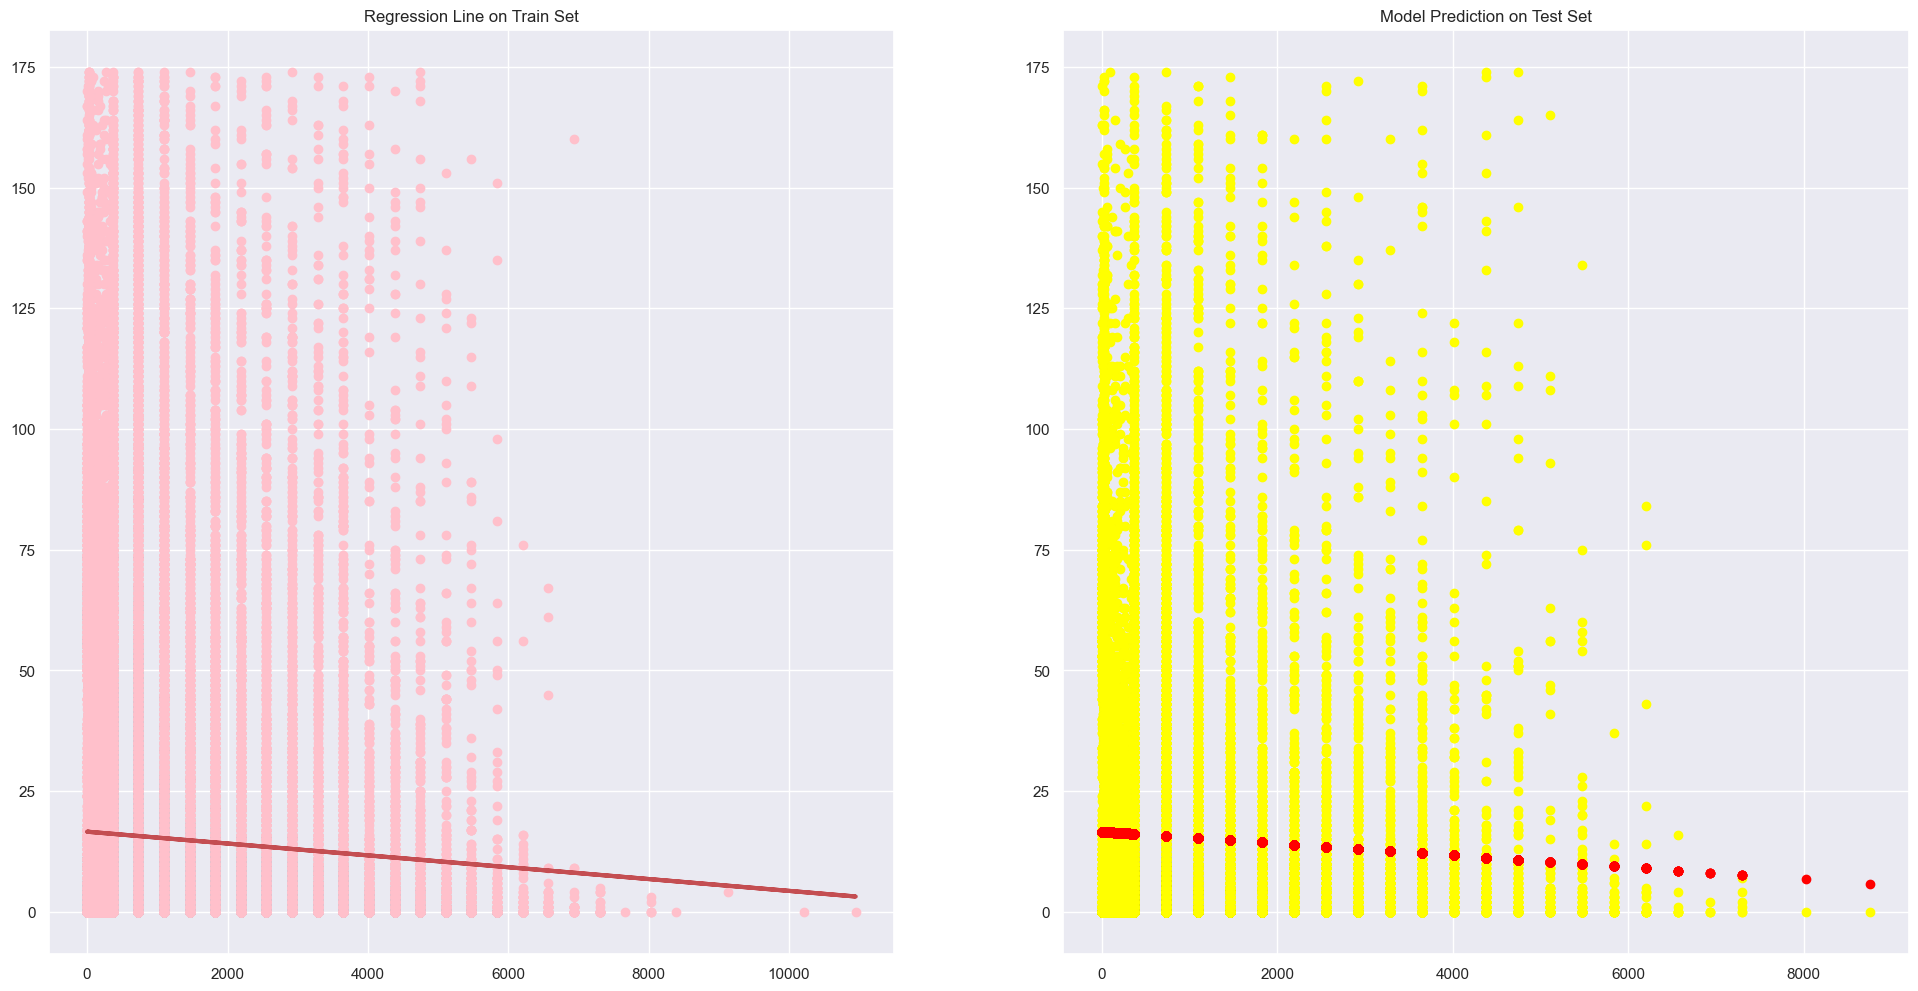

,R^2 Score,MSE
Train Set,0.002408,652.475273
Test Set,0.001750,667.213387


In [13]:
  # Plot the Predictions vs the True values
  f, axes = plt.subplots(1, 2, figsize=(24, 12))

  axes[0].scatter(X_train, y_train, color="pink")
  axes[0].plot(regline_x, regline_y, 'r-', linewidth = 3)
  axes[0].set_title("Regression Line on Train Set")

  axes[1].scatter(X_test, y_test, color = "yellow")
  axes[1].scatter(X_test, y_test_pred, color = "red")
  axes[1].set_title("Model Prediction on Test Set")

  plt.show()

  compare = pd.DataFrame(np.array([[r2_score(y_train, y_train_pred), mean_squared_error(y_train, y_train_pred)],
                                     [r2_score(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred)]]),
                      columns=['R^2 Score', 'MSE'],
                      index =['Train Set','Test Set'])

  display(compare)

# **2. Using Numerical and Categorical Data**

# **2.1 General Feature Selection & Data Preparation**

# **2.1.1 ANOVA Test**

ANOVA is a powerful tool for comparing means across multiple groups. By analyzing the variance within and between groups, it allows us to assess the statistical significance of observed differences.

In [14]:
#Create different groups for ANOVA

group1 = data[data['IntakeCondition'] == 'Normal']['Days_length2']
group2 = data[data['IntakeCondition'] == 'Sick']['Days_length2']
group3 = data[data['IntakeCondition'] == 'Injured']['Days_length2']

#Perform the ANOVA test
f_value, p_value = stats.f_oneway(group1, group2, group3)

#Print the results
print("ANOVA test results:")
print("F-Value:", f_value, "P-Value:", p_value)

# Now perform Tukey's HSD test for pairwise comparisons
tukey_results = pairwise_tukeyhsd(data['Days_length2'], data['IntakeCondition'], alpha=0.05)

# Convert the results to a DataFrame for easier reading
tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])

# Display the table with all pairwise comparisons
display(tukey_df)

# Interpretation of results
# (This is based on individual group comparisons from Tukey's test now)
print("Pairwise comparison results (Tukey's HSD):")
for index, row in tukey_df.iterrows():
    print(f"{row['group1']} vs {row['group2']} - Tukey HSD test statistic: {row['meandiff']} P-Value: {row['p-adj']}")


ANOVA test results:
F-Value: 141.89141397989567 P-Value: 2.7362500761891012e-62


,group1,group2,meandiff,p-adj,lower,upper,reject
0,Aged,Agonal,-6.0412,1.0000,-69.7861,57.7038,False
1,Aged,Behavior,18.3952,0.0001,5.5964,31.1940,True
2,Aged,Congenital,-9.0412,1.0000,-99.0977,81.0154,False
3,Aged,Feral,4.8927,0.8997,-3.8346,13.6199,False
4,Aged,Injured,7.1471,0.0000,2.9562,11.3381,True
...,...,...,...,...,...,...,...
166,Parvo,Sick,10.6978,1.0000,-41.2548,62.6504,False
167,Parvo,Unknown,27.6000,0.9730,-29.2982,84.4982,False
168,Pregnant,Sick,-12.4044,0.0000,-20.1701,-4.6387,True
169,Pregnant,Unknown,4.4978,1.0000,-19.9694,28.9650,False


Pairwise comparison results (Tukey's HSD):
Aged vs Agonal - Tukey HSD test statistic: -6.0412 P-Value: 1.0
Aged vs Behavior - Tukey HSD test statistic: 18.3952 P-Value: 0.0001
Aged vs Congenital - Tukey HSD test statistic: -9.0412 P-Value: 1.0
Aged vs Feral - Tukey HSD test statistic: 4.8927 P-Value: 0.8997
Aged vs Injured - Tukey HSD test statistic: 7.1471 P-Value: 0.0
Aged vs Med Attn - Tukey HSD test statistic: 0.9588 P-Value: 1.0
Aged vs Med Urgent - Tukey HSD test statistic: -7.8983 P-Value: 1.0
Aged vs Medical - Tukey HSD test statistic: 11.3516 P-Value: 0.0
Aged vs Neonatal - Tukey HSD test statistic: 10.5341 P-Value: 0.0
Aged vs Neurologic - Tukey HSD test statistic: -8.93 P-Value: 0.9999
Aged vs Normal - Tukey HSD test statistic: 5.6625 P-Value: 0.0002
Aged vs Nursing - Tukey HSD test statistic: 12.068 P-Value: 0.0
Aged vs Other - Tukey HSD test statistic: 8.6098 P-Value: 0.0005
Aged vs Panleuk - Tukey HSD test statistic: -9.0412 P-Value: 1.0
Aged vs Parvo - Tukey HSD test sta

# **2.1.2 Encode using One Hot Encoding**

One-hot encoding is a popular technique for converting categorical variables into a format suitable for machine learning models. By creating binary features for each category, it provides a clear and interpretable representation for the model to learn from. 

In [15]:
# Select categorical variables
data_categorical = data[['IntakeCondition', 'Animal_Type_intake', 'Sex', 'Breed_intake', 'Color_intake', 'Outcome_Type']]

# Initialize the OneHotEncoder
ohe = OneHotEncoder(sparse=False)

# Fit the encoder on the data
ohe.fit(data_categorical)

# Transform the data using the fitted encoder
data_encoded = ohe.transform(data_categorical)

# Create a new DataFrame with the transformed data and appropriate column names
dataOH = pd.DataFrame(data_encoded, columns=ohe.get_feature_names_out(data_categorical.columns))

# Display the first few rows of the new DataFrame
dataOH.head()

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,IntakeCondition_Aged,IntakeCondition_Agonal,IntakeCondition_Behavior,IntakeCondition_Congenital,IntakeCondition_Feral,IntakeCondition_Injured,IntakeCondition_Med Attn,IntakeCondition_Med Urgent,IntakeCondition_Medical,IntakeCondition_Neonatal,...,Outcome_Type_Disposal,Outcome_Type_Euthanasia,Outcome_Type_Lost,Outcome_Type_Missing,Outcome_Type_Relocate,Outcome_Type_Return to Owner,Outcome_Type_Rto-Adopt,Outcome_Type_Stolen,Outcome_Type_Transfer,Outcome_Type_Unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# **2.2 Decision Tree**

# **2.2.1 Decision Tree Regression Model for Predicting Shelter Animal Length of Stay**

Decision tree regression is a flexible and interpretable model for predicting continuous values. By recursively splitting the data based on features, it builds a tree-like structure that allows for clear understanding of the factors influencing the prediction.

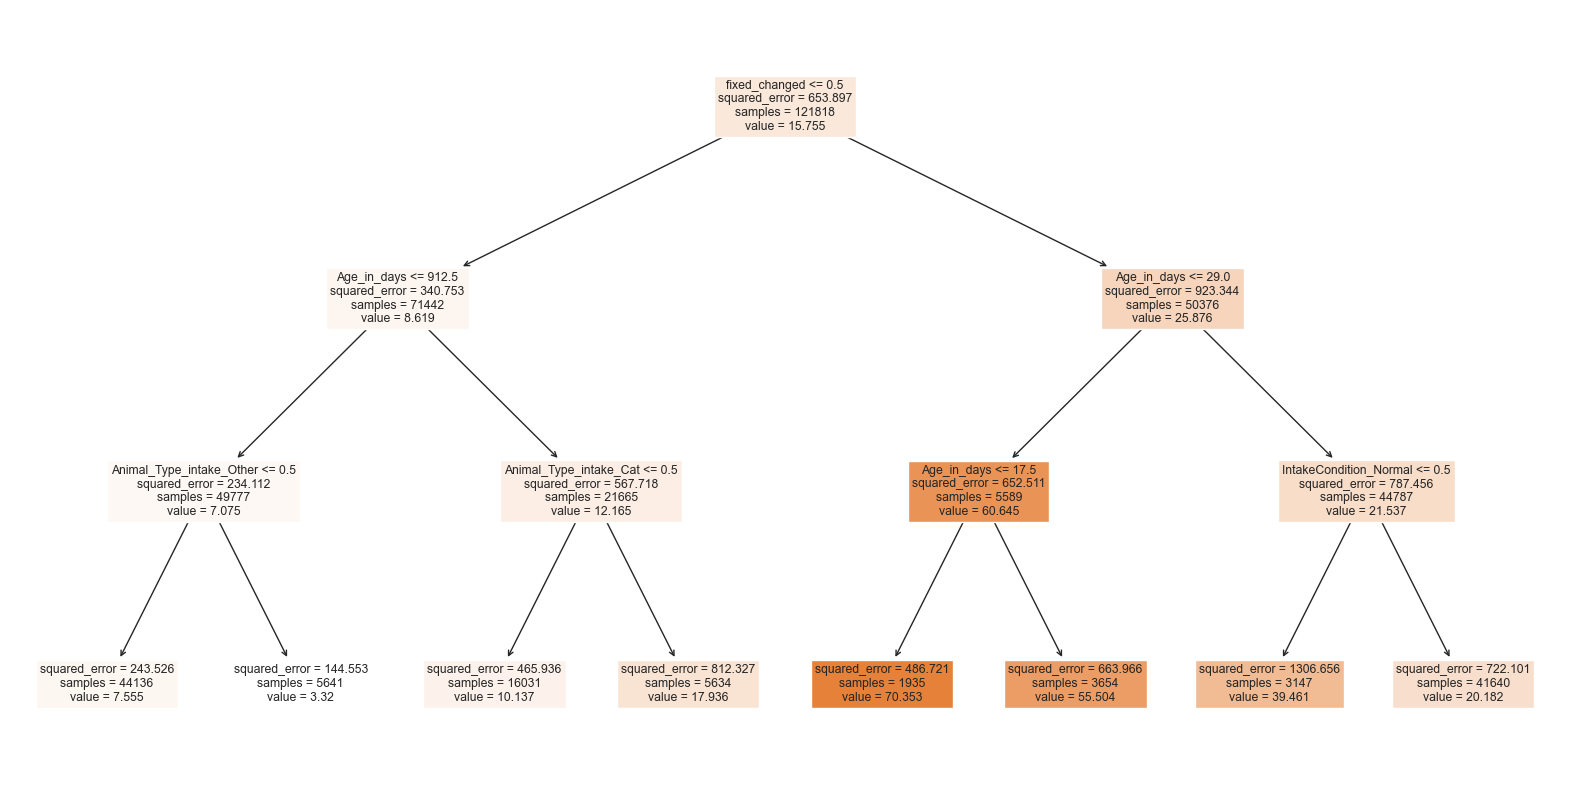

Train R-squared: 0.2322279043841623
Train MSE: 502.0440702990702
Test R-squared: 0.22747208059076718
Test MSE: 516.8362851173853


In [16]:
#Selecting categorical variables
X = data[['IntakeCondition', 'Animal_Type_intake', 'Breed_intake', 'Color_intake', 'fixed_changed', 'Age_in_days']]
# Target variable
y = data['Days_length2']

#Encoding categorical variables (if needed)
X_encoded = pd.get_dummies(X)

#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#Initialize the decision tree regressor
clf = DecisionTreeRegressor(max_depth=3)

#Train the regressor
clf.fit(X_train, y_train)

#Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X_encoded.columns.tolist())
plt.show()

#Model Evaluation
# Predictions on the training set
y_train_pred = clf.predict(X_train)

#Calculate R-squared for the training set
train_r2 = r2_score(y_train, y_train_pred)
print("Train R-squared:", train_r2)

#Calculate MSE for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE:", train_mse)

#Predictions on the test set
y_test_pred = clf.predict(X_test)

#Calculate R-squared for the test set
test_r2 = r2_score(y_test, y_test_pred)
print("Test R-squared:", test_r2)

#Calculate MSE for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_mse)

# **2.2.2 Cross Validation**

Cross-validation is a valuable tool in machine learning. By splitting data into folds and iteratively training and testing on different subsets, it helps reduce overfitting and provides a more reliable estimate of a model's generalizability to unseen data.

In [17]:
print(X_encoded.shape)  # Should output (number_of_samples, number_of_features)
print(y.shape)  # Should output (number_of_samples,)

# Initialize the decision tree regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Define the number of folds for cross-validation
k = 5  # This means the data will be divided into 5 subsets

# Perform k-fold cross-validation
cv_scores = cross_val_score(dt_regressor, X_encoded, y, cv=k, scoring='neg_mean_squared_error')

# Convert the scores to positive mean squared error
mse_scores = -cv_scores

# Calculate the average and standard deviation of the MSE across all folds
average_mse = mse_scores.mean()
std_dev_mse = mse_scores.std()

# Print the results
print(f'Average MSE across all folds: {average_mse}')
print(f'Standard Deviation of MSE across all folds: {std_dev_mse}')

# If ou want to also see the R-squared scores you can do another cross-validation
cv_scores_r2 = cross_val_score(dt_regressor, X_encoded, y, cv=k, scoring='r2')

# Calculate the average and standard deviation of the R-squared scores
average_r2 = cv_scores_r2.mean()
std_dev_r2 = cv_scores_r2.std()

# Print the results
print(f'Average R-squared across all folds: {average_r2}')
print(f'Standard Deviation of R-squared across all folds: {std_dev_r2}')

(152273, 3525)
(152273,)
Average MSE across all folds: 610.8284818801725
Standard Deviation of MSE across all folds: 22.65856819779723
Average R-squared across all folds: 0.049381482601313566
Standard Deviation of R-squared across all folds: 0.11586274740515004


# **2.3 Random Forest**

# **2.3.1 Data Preprocessing and Feature Encoding**

Data preprocessing ensures your data is clean, consistent, and ready for analysis. Feature encoding translates categorical data into a format that machine learning models can understand. By performing these steps, you prepare your data for accurate and efficient model training.

In [18]:
#Creating a dictionary of label encoders for categorical features
label_encoders = {}

for column in ['Animal_Type_intake', 'Sex', 'Breed_intake', 'Color_intake', 'IntakeCondition']:
    label_encoders[column] = LabelEncoder()
    #Encoding categorical columns to convert them to numerical values
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

# **2.3.2 Random Forest Classifier Training and Feature Importance Analysis**

Random Forest Classifiers build a robust ensemble of decision trees to predict categorical outcomes. Feature importance analysis helps identify the most significant factors influencing those predictions. This knowledge can be valuable for understanding which animal characteristics play the biggest role in adoption rates.

In [19]:
#Creating a binary target variable for the classification problem
data['Outcome_Adopted'] = data['Outcome_Type'].apply(lambda x: 1 if x == 'Adoption' else 0)

#Selecting featurs for the model
features = ['Age', 'Animal_Type_intake', 'Sex', 'Breed_intake', 'Color_intake', 'IntakeCondition', 'Days_length']  # Example features

#Specifying the target variable for prediction
target = 'Outcome_Adopted'

#Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

#Training the classifier on the training data
rf_classifier.fit(X_train, y_train)

#Computing feature importances and sorting them
feature_importances = pd.DataFrame(rf_classifier.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
#Displaying feature importances
print(feature_importances)

                                                    importance
Age_in_days                                           0.366827
fixed_changed                                         0.064425
Color_intake_Black/White                              0.009721
IntakeCondition_Normal                                0.008711
Color_intake_Brown                                    0.007091
...                                                        ...
Breed_intake_australian kelpie/shiba inu              0.000000
Breed_intake_australian kelpie/plott hound            0.000000
Breed_intake_miniature schnauzer/soft coated wh...    0.000000
Breed_intake_pointer/english coonhound                0.000000
Color_intake_Yellow/Yellow                            0.000000

[3525 rows x 1 columns]


# **2.3.3 Regression Problem Setup and Data Splitting**

Proper problem definition and data splitting are essential steps in building a good regression model. By clearly identifying the target variable and features, and then splitting the data for training, validation (optional), and testing, you ensure the model learns from the data and generalizes well to predict unseen values.

In [20]:
#Selecting the features for the regression problem
X = data[['Age_in_days', 'fixed_changed']]

#Specifying the target variable for the regression problem
y = data['Days_length2']

#Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **2.3.4 Random Forest Regressor Training and Prediction**

Random forest regression is an ensemble technique that builds a "forest" of decision trees to predict continuous values (like price or length of stay). Each tree votes on the prediction, and the final output is the average of these votes, leading to more robust and accurate predictions.

In [21]:
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_regressor.fit(X_train, y_train)

# Making predictions on both the training and testing datasets
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# **2.3.5 2D Scatter Plot for Actual vs. Predicted Values**

Scatter plots help us visualize relationships between two numerical variables. Each dot represents a data point, positioned based on the values of both variables. Clusters of dots suggest a connection, with diagonal clusters indicating a positive correlation (both variables increase or decrease together) and vice versa. The tighter the cluster, the stronger the relationship. Scatter plots also help identify outliers, data points far from the main cluster that might warrant further exploration.

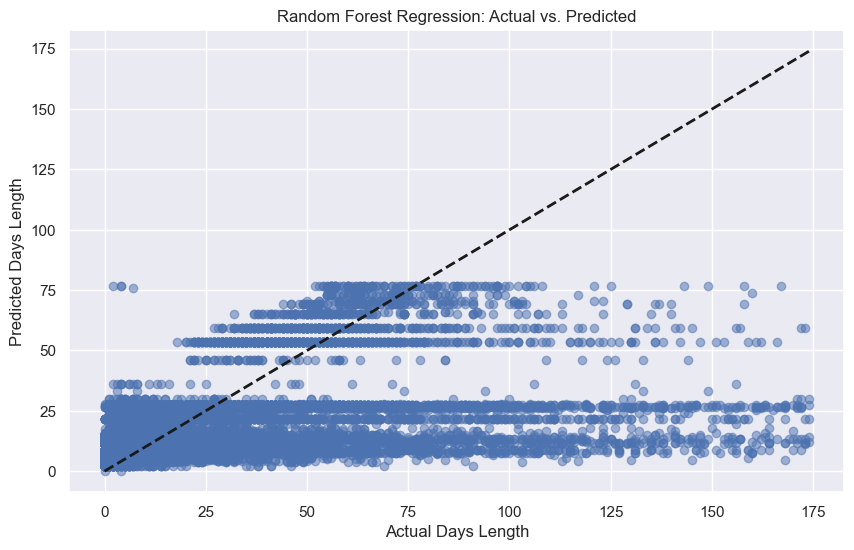

In [22]:
#Creating a 2D scatter plot for the actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)

#Drawing a line representing the perfect predictions for reference
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)

#Labeling the axes and setting the title of the plot
plt.xlabel('Actual Days Length')
plt.ylabel('Predicted Days Length')
plt.title('Random Forest Regression: Actual vs. Predicted')

#Displaying the plot
plt.show()

# **2.3.6 3D Scatter Plot for Actual vs. Predicted Values**

3D scatter plots take the concept of visualizing relationships between two variables and add another dimension. Imagine a box with three axes, each representing a numerical variable. Data points are plotted within this space, and their position reflects their values on all three axes. By rotating the plot or using specialized software, we can explore how the points cluster and distribute themselves in this 3D space. These clusters and their depth can reveal interesting connections between the variables.  However, interpreting 3D plots can be trickier than 2D versions, and often requires software assistance.  Despite the added complexity, 3D scatter plots are a valuable tool for uncovering hidden patterns and interactions within your data.

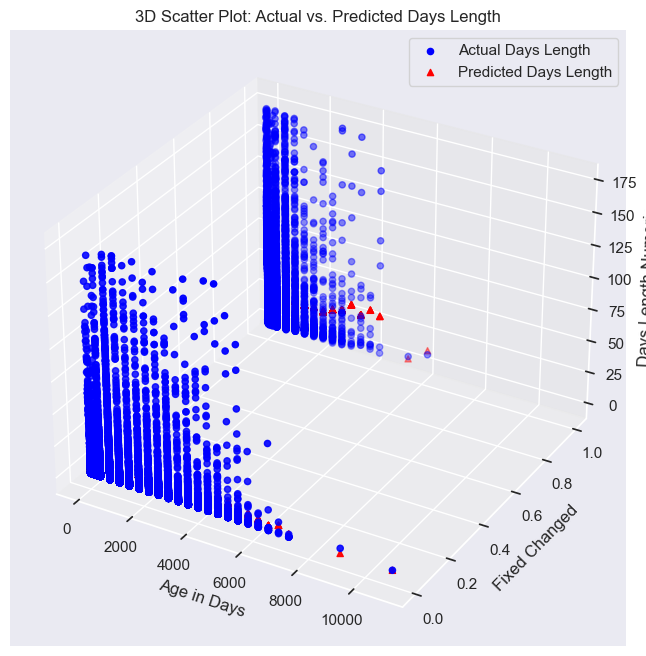

In [23]:
#Setting up a 3D figure for visualization
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

#Scatter plot for the actual target values from the test set
sc1 = ax.scatter(X_test['Age_in_days'], X_test['fixed_changed'], y_test, color='blue', label='Actual Days Length')

#Scatter plot for the predicted target values from the test set
sc2 = ax.scatter(X_test['Age_in_days'], X_test['fixed_changed'], y_test_pred, color='red', label='Predicted Days Length', marker='^')

#Setting the labels and title for the 3D plot
ax.set_xlabel('Age in Days')
ax.set_ylabel('Fixed Changed')
ax.set_zlabel('Days Length Numeric')
ax.set_title('3D Scatter Plot: Actual vs. Predicted Days Length')

#Adding a legend to the plot
ax.legend()

#Displaying the 3D plot
plt.show()

# **2.3.7 Model Performance Metrics**

Evaluating how well a model performs relies on different metrics. Accuracy tells you the overall success rate of predictions. Precision focuses on the quality of positive predictions, ensuring they're truly correct. Recall looks at how well the model catches all positive cases. F1-Score combines these for a balanced view. Finally, AUC-ROC measures the model's ability to separate positive and negative examples, especially useful in problems with two categories.

In [24]:
#Calculating and printing the Mean Squared Error (MSE) and R-squared (R^2) for the training and test sets

print("Training MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Training R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))

Training MSE: 498.4843430616434
Test MSE: 513.7505673076183
Training R^2: 0.23767176758778885
Test R^2: 0.23208437896862177


# **2.4 Lasso Regression**

Lasso regression is a technique used in machine learning to improve model performance by:

Reducing overfitting: It penalizes overly complex models, shrinking the influence of certain features (coefficients) to prevent the model from memorizing training data.

Selecting important features: By shrinking coefficients to zero, Lasso regression effectively removes irrelevant features from the model, focusing on the most important ones for prediction.

This balancing act is achieved through a parameter (lambda) that controls the strength of the penalty. Lasso regression helps create interpretable and accurate models by identifying the key factors that influence the target variable.

In [25]:
# Select features and target variable
X = data[['Age_in_days', 'Animal_Type_intake','Breed_intake']]
y = data['Outcome_Type']  # Replace 'Target' with the name of the target column

# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Lasso regression model with an alpha value
lasso = Lasso(alpha=1.0)

# Train the model
lasso.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

# Decode the predicted labels back to original string values
y_train_pred_original = label_encoder.inverse_transform(y_train_pred.round().astype(int))
y_test_pred_original = label_encoder.inverse_transform(y_test_pred.round().astype(int))

# Evaluate the model performance
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate R-squared for training set
train_r2 = r2_score(y_train, y_train_pred)

# Calculate R-squared for testing set
test_r2 = r2_score(y_test, y_test_pred)

print(f'Training Mean Squared Error: {train_mse}')
print(f'Test Mean Squared Error: {test_mse}')
print(f'Training R-squared: {train_r2}')
print(f'Test R-squared: {test_r2}')

# Inspect the coefficients
coefficients = pd.DataFrame(lasso.coef_, index=X.columns, columns=['Coefficient'])
print(coefficients)

# Non-zero coefficients indicate relevant features, while zero coefficients suggest less important features

Training Mean Squared Error: 19.634127180597098
Test Mean Squared Error: 19.569667740564995
Training R-squared: 0.0
Test R-squared: -5.319835968409237e-05
                    Coefficient
Age_in_days                 0.0
Animal_Type_intake         -0.0
Breed_intake                0.0


# **2.5 XGBoost**

XGBoost is a more advanced version of gradient boosting that use decision trees to build an ensemble model. It is popular because of its performance and quickness, as well as its ability to run in a variety of computing settings. It manages huge datasets efficiently and provides useful insights into feature importance because to features such as parallel processing and built-in cross-validation. XGBoost is versatile, enabling a wide range of predictive modeling workloads.

MSE: 18.55
R-squared: 0.05


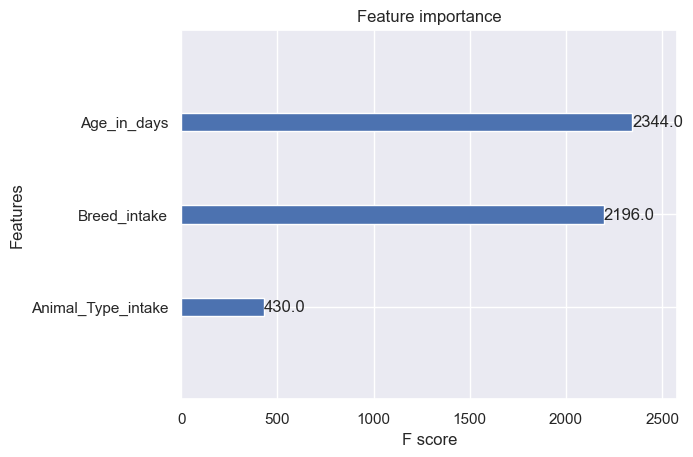

In [26]:
# Initialize XGBoost regressor model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

# Train the model with the training set
xg_reg.fit(X_train, y_train)

# Predict the target variable for the testing set
y_pred = xg_reg.predict(X_test)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared: %.2f" % r2)

# Train an XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Plot feature importance
plot_importance(model)
plt.show()